<a href="https://colab.research.google.com/github/pollyjuice74/LDPC-codes/blob/main/quintuple_decoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**SKIP THIS SECTION**

In [2]:
# Import TensorFlow and NumPy
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Import Sionna
'''try:
    import sionna as sn
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna as sn'''

# For plotting
%matplotlib inline
# also try %matplotlib widget

In [3]:
'''from sionna.fec.utils import load_parity_check_examples, LinearEncoder, GaussianPriorSource
from sionna.utils import BinarySource, ebnodb2no, BitwiseMutualInformation, hard_decisions
from sionna.utils.metrics import compute_ber
from sionna.utils.plotting import PlotBER
from sionna.mapping import Mapper, Demapper
from sionna.channel import AWGN
from sionna.fec.ldpc import LDPCBPDecoder
from sionna.fec.linear import OSDecoder'''

from tensorflow.keras.layers import Dense, Layer

!pip install torch-geometric

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data, DataLoader


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 10.3 MB/s eta 0:00:00


---

# In the following cells there is the implementation for a quintuple decoder and a plot of the Bit Error Rates with the Error Probabilities.

---



In [4]:
############################################################
### READ THE COMMENTS IF YOU DON'T WANT TO READ THE CODE ###
############################################################

# This cell just GENERATES the DATA


n = 10 # number of bits sent
err_prob = 0.3 # error probability
rep = 5 # ammount of times a bit will be repeated

def generate_data(n, err_prob):
  # Create random bits and repeat 5 times
  bits = np.random.randint(0, 2, size=n)
  repeat_bits = np.repeat(bits, rep)

  # Create noise with a given error probability
  noise = np.random.rand(n*rep) < err_prob
  noisy_bits = np.logical_xor(repeat_bits, noise).astype(int)

  # Return "recieved" repeated noisy bits, and original bits sent
  return torch.tensor(noisy_bits, dtype=float), torch.tensor(bits)


# Call generate data function
noisy_bits, bits = generate_data(n, err_prob)

# Example data
bits, noisy_bits

(tensor([0, 0, 1, 0, 1, 0, 1, 1, 0, 0]),
 tensor([0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0.,
         1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
         1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
        dtype=torch.float64))

In [5]:
# This cell is for DECODING using majority voting system


def decode_bits(noisy_bits, original_bits):
  # Reshape the noisy bits recieved to (num bits sent, quintuple repetitions) shaped tensor
  noisy_bits = noisy_bits.reshape(-1, rep)

  # Calculate the mean of the repetitions
  decoded_bits = torch.mean(noisy_bits, axis=1).round().to(torch.int32)

  # Calculate Bit Error Rate
  error = torch.sum(decoded_bits != original_bits)
  ber = error / n

  return decoded_bits, ber


# Call decoding function
decoded_bits, ber = decode_bits(noisy_bits, bits)

# Example data
decoded_bits.shape, ber

(torch.Size([10]), tensor(0.1000))

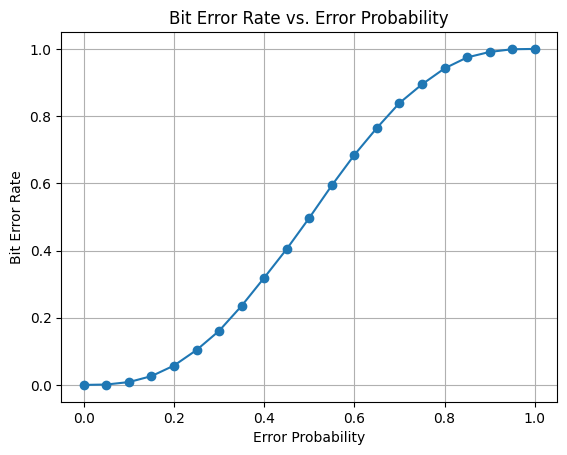

In [6]:
# This cell CALCULATES Bit Error Rates(BER) given Error Probabilities and plots them in a graph


error_probs = np.arange(0, 1.05, 0.05) # List of Error Probabilityies as x coordinate
ber_values = [] # List of Bit Error Rates as the y coordinate
n = 100000 # Number of sent bits

# Loop to calculate the BER for each error probability
for error_prob in error_probs:
    # Generate random bits and noisy recieved bits
    noisy_bits, original_bits = generate_data(n, error_prob)
    # Decodes recieved bits and calculates BER
    decoded_bits, ber = decode_bits(noisy_bits, original_bits)
    ber_values.append(ber)

# Plotting
plt.plot(error_probs, ber_values, marker='o')
plt.title('Bit Error Rate vs. Error Probability')
plt.xlabel('Error Probability')
plt.ylabel('Bit Error Rate')
plt.grid(True)
plt.show()

---

### For fun, this part is the implementation of a GNN for the purpose of the same quintuple bit error decoder.

---

In [9]:
# This cell defines a function to CREATE A BATCH OF DATA

def create_graph_data(noisy_bits, original_bits, rep=5):
  # Reshape quintuple repeated bit tensor of shape (50,) to (10, 5)
  #   i.e. this makes each repeated bit into ONE NODE,
  #   EACH NODE is the BIT repeated 5 times
  x = torch.tensor(noisy_bits, dtype=torch.float).view(-1, rep)

  # Makes the original 10 bits array into a tensor of shape (10,1)
  y = torch.tensor(original_bits, dtype=torch.float)

  # This loop FILLS an EDGE INDEX TENSOR of shape (2, 10)
  #   [i, i+1] being the node i connected to the node i+1
  #   This is repeated 10 times for the 10 bits/nodes sent
  edge_index = list()
  for i in range(x.size(0)-1):
    edge_index.append([i, i+1])
    edge_index.append([i+1, i])
  edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

  # Creates DATA OBJECT
  return Data(x=x, edge_index=edge_index, y=y)


# TRAINING DATA
# Using the previously defined function, create a graph data list, this will serve as the
graph_data_list = [create_graph_data(*generate_data(n, err_prob)) for _ in range(100)]

<ipython-input-9-47eae122f8f1>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(noisy_bits, dtype=torch.float).view(-1, rep)
<ipython-input-9-47eae122f8f1>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(original_bits, dtype=torch.float)
/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [17]:
# This cell DEFINES a simple two layer GNN

n = 10
rep = 5
hidden_size = 16

class GNNDecoder(nn.Module):
  def __init__(self):
    super(GNNDecoder, self).__init__()
    # LAYERS OF THE NETWORK
    self.conv1 = GCNConv(rep, hidden_size) # (5, 16)
    self.conv2 = GCNConv(hidden_size, 1) # (16, 1)

  def forward(self, data):
    # Gets input graph data and edges
    x, edge_index = data.x, data.edge_index

    # Activation function for the first layer
    x = F.relu(self.conv1(x, edge_index))
    # Activation function for the second layer
    x = torch.sigmoid(self.conv2(x, edge_index))
    return x

model = GNNDecoder()

In [18]:
train_loader = DataLoader(graph_data_list, batch_size=1, shuffle=True)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [26]:
# Training loop

num_epochs = 20

for epoch in range(num_epochs):
  model.train()
  epoch_loss = 0

  for data in train_loader:
    outputs = model(data)
    loss = criterion(torch.squeeze(outputs), data.y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()

  print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(train_loader)}')

Epoch [1/20], Loss: 0.6380134373903275
Epoch [2/20], Loss: 0.6380005085468292
Epoch [3/20], Loss: 0.6379889786243439
Epoch [4/20], Loss: 0.6379797482490539
Epoch [5/20], Loss: 0.6379700845479965
Epoch [6/20], Loss: 0.6379601162672043
Epoch [7/20], Loss: 0.6379506200551986
Epoch [8/20], Loss: 0.6379444545507431
Epoch [9/20], Loss: 0.6379377871751786
Epoch [10/20], Loss: 0.6379324573278428
Epoch [11/20], Loss: 0.637928056716919
Epoch [12/20], Loss: 0.6379228800535202
Epoch [13/20], Loss: 0.6379199802875519
Epoch [14/20], Loss: 0.6379184436798095
Epoch [15/20], Loss: 0.6379147517681122
Epoch [16/20], Loss: 0.6379115599393844
Epoch [17/20], Loss: 0.6379094910621643
Epoch [18/20], Loss: 0.6379080450534821
Epoch [19/20], Loss: 0.6379064029455185
Epoch [20/20], Loss: 0.6379051971435546


In [30]:
# Creates TEST DATA

test_data = [create_graph_data(*generate_data(n, err_prob)) for _ in range(1000)]
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

<ipython-input-9-47eae122f8f1>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(noisy_bits, dtype=torch.float).view(-1, rep)
<ipython-input-9-47eae122f8f1>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(original_bits, dtype=torch.float)


In [31]:
# EVALUATE MODEL'S PERFORMANCE

model.eval()

cor_pred = 0
total_pred = 0

with torch.no_grad():
  for data in test_loader:
    outputs = model(data)
    predicted = torch.squeeze(outputs).round()

    cor_pred += (predicted == data.y).sum().item()
    total_pred += data.y.size(0)

  acc = cor_pred / total_pred
  print(f"Test Accuracy: {acc} = {cor_pred}/{total_pred}")

Test Accuracy: 0.6949 = 6949/10000


###Comparing the **GNN** and the simple **majority voting system(MVS)** algorithm, we can see that the **MVS(accuracy of 0.9)** outperformed the **GNN(accuracy of ~0.7)**